# 血液透析：14 天後 HB 範圍是否在 11-12 之間且變化幅度在正負0.5之間(最佳化)？

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import math
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

**讀檔**

In [ ]:
#讀取excel檔案
df = pd.read_excel('train_dialysis.xlsx')

In [ ]:
#7067 rows × 91 columns
df

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,...,c82,c83,c84,c85,c86,c87,c88,c89,c90,label
0,1.61,1.71,1250,1,1.0,1.0,40.0,5,2.5,1250,...,698.9,293.0,250.0,53.0,0.60,67.7,81.2,280.0,1.325,0
1,1.61,1.71,1250,1,1.0,1.0,40.0,5,2.5,1250,...,698.9,293.0,250.0,53.0,0.60,67.7,81.2,280.0,1.100,0
2,1.61,1.71,1250,1,1.0,1.0,40.0,5,2.5,1250,...,698.9,293.0,250.0,53.0,0.60,67.7,81.2,280.0,1.050,0
3,1.61,1.71,1250,1,1.0,1.0,40.0,5,2.5,1250,...,698.9,293.0,250.0,53.0,0.60,67.7,81.2,280.0,1.100,0
4,1.61,1.71,1250,1,1.0,1.0,40.0,5,2.5,1250,...,698.9,293.0,250.0,53.0,0.60,67.7,81.2,280.0,1.100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7062,1.60,1.70,1250,1,1.0,1.0,20.0,1,2.5,1250,...,260.8,84.0,231.0,40.0,1.25,55.7,84.0,265.0,3.750,1
7063,1.60,1.70,1250,1,1.0,1.0,20.0,1,2.5,1250,...,260.8,84.0,231.0,40.0,1.25,55.7,84.0,265.0,3.750,0
7064,1.60,1.70,1250,1,1.0,1.0,20.0,1,2.5,1250,...,260.8,84.0,231.0,40.0,1.25,55.7,84.0,265.0,3.750,0
7065,1.60,1.70,1250,1,1.0,1.0,20.0,1,2.5,1250,...,260.8,84.0,231.0,40.0,1.25,55.7,84.0,265.0,3.750,0


**拆分訓練集與測試集**

In [ ]:
#將df以7:3比例分為training set與test set
train_df, test_df = train_test_split(df, test_size = 0.3, random_state = 0)

In [ ]:
train_df  #4946筆

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,...,c82,c83,c84,c85,c86,c87,c88,c89,c90,label
3318,1.70,1.800,1250,1,1.0,0.5,40.0,1,2.5,1250,...,621.6,51.0,260.0,36.0,0.20,77.5,63.2,280.0,1.1500,0
2701,1.60,1.680,1000,2,1.0,1.0,40.0,1,2.5,1250,...,532.2,223.0,257.0,69.0,0.10,89.0,67.2,280.0,1.5625,0
5862,1.60,1.700,0,2,2.0,1.0,50.0,1,2.5,1250,...,341.4,572.0,146.0,49.0,0.74,37.8,54.0,150.0,0.5000,0
3595,1.64,1.735,250,1,1.0,0.5,40.0,1,3.0,1250,...,24.0,338.0,184.0,70.0,0.20,36.6,49.5,280.0,1.2750,0
2377,1.60,1.680,1000,2,1.0,1.0,40.0,1,2.5,1250,...,1145.6,189.0,218.0,63.0,0.10,61.4,79.5,280.0,1.6750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,1.60,1.700,0,2,1.0,1.5,40.0,1,3.0,1250,...,10.2,696.0,320.0,66.0,0.20,77.3,74.0,280.0,0.9500,0
3264,1.70,1.800,1250,1,1.0,0.5,40.0,1,2.5,1250,...,621.6,147.0,222.0,68.0,0.20,44.2,63.2,280.0,1.1500,0
1653,1.63,1.720,750,2,1.0,1.0,50.0,1,2.5,1250,...,233.4,559.0,212.0,42.0,0.28,70.2,56.5,280.0,1.4375,1
2607,1.68,1.780,1000,2,0.0,0.5,40.0,1,2.5,1250,...,147.4,698.0,175.0,40.0,0.20,63.4,37.0,280.0,1.8500,0


In [ ]:
test_df  #2121筆

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,...,c82,c83,c84,c85,c86,c87,c88,c89,c90,label
1091,1.640,1.740,1250,1,0.0,1.0,40.0,5,3.0,1250,...,297.60,197.0,280.0,68.0,2.80,47.9,59.0,280.0,2.8750,0
2194,1.600,1.675,1000,2,1.0,1.0,40.0,1,3.0,1250,...,61.60,46.0,306.0,30.0,0.10,41.7,64.5,280.0,1.0000,1
2921,1.600,1.670,1000,1,2.0,0.5,10.0,1,3.5,1250,...,138.60,938.0,196.0,37.0,0.10,54.0,89.5,280.0,3.6000,0
878,1.620,1.730,1250,2,2.0,1.0,40.0,5,3.0,1250,...,712.50,1043.0,221.0,84.0,2.80,58.6,44.3,280.0,0.8125,0
3093,1.760,1.865,1250,1,2.0,0.5,40.0,1,3.0,1250,...,33.10,205.0,238.0,72.0,0.20,75.2,70.5,275.0,1.1750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6605,1.700,1.800,0,1,1.0,1.0,30.0,1,3.5,1250,...,363.10,385.0,189.0,46.0,0.20,69.5,43.5,280.0,1.1500,0
6698,1.600,1.700,0,1,1.0,1.0,50.0,1,3.5,1250,...,100.50,333.0,199.0,60.0,0.50,49.7,52.0,280.0,0.8000,0
2161,1.610,1.685,1000,2,1.0,1.0,40.0,1,3.0,1250,...,61.60,46.0,306.0,30.0,0.10,41.7,64.5,280.0,1.0000,1
4462,1.625,1.695,1000,2,0.0,0.5,40.0,1,2.5,1250,...,216.06,673.0,237.0,99.0,0.20,56.9,51.7,280.0,1.1500,1


**Feature selection: 
以統計方法(p-value)挑選特徵**

**類別型特徵 (前40種)
使用chi-square**

- 卡方檢定用於分析**兩類別**變數間的關係

![連結文字](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRqKhq6X9OG0p230UBLWcquGg3w6ZvUMWTgIw&usqp=CAU)


In [ ]:
cat_df = train_df.iloc[:,0:39]
cat_df = pd.concat([cat_df, train_df['label']], axis = 1)

cat_p_value = []
cat_df = cat_df[cat_df['label'] >= 0]
titles = list(cat_df.columns)
for i in titles:
    table = pd.crosstab(cat_df['label'],cat_df[i])
    chi2, p, dof, expected = chi2_contingency(table)
    cat_p_value.append(p) 
d1_d39_p_value = pd.DataFrame([titles, cat_p_value]).T
d1_d39_p_value = d1_d39_p_value.rename(columns = {0:'features', 1:'p_value'})
print(d1_d39_p_value)

   features   p_value
0        d1       0.0
1        d2       0.0
2        d3       0.0
3        d4  0.003324
4        d5   0.00018
5        d6       0.0
6        d7       0.0
7        d8       0.0
8        d9       0.0
9       d10       1.0
10      d11       0.0
11      d12  0.497714
12      d13  0.041647
13      d14       0.0
14      d15       0.0
15      d16       1.0
16      d17  0.693455
17      d18  0.400225
18      d19  0.540064
19      d20       0.0
20      d21       0.0
21      d22       0.0
22      d23  0.000173
23      d24  0.046561
24      d25       1.0
25      d26  0.876397
26      d27  0.032762
27      d28       0.0
28      d29       0.0
29      d30       0.0
30      d31       0.0
31      d32       0.0
32      d33       0.0
33      d34  0.007811
34      d35    0.7026
35      d36  0.432851
36      d37       0.0
37      d38  0.271168
38      d39  0.032762
39    label       0.0


In [ ]:
cont_df = train_df.iloc[:,39:90]
cont_df = pd.concat([cont_df, train_df['label']], axis = 1)
cont_df = cont_df[cont_df['label'] >= 0]
titles = list(cont_df.columns)

c_p_value = []
for i in titles:
    value1=[]
    value0=[]
    my_col = cont_df[[i,'label']]
    for j in range(0, my_col.shape[0]):
        if (str(my_col.iloc[j,1]) == '1'):
            value1.append(my_col.iloc[j,0])
        elif (str(my_col.iloc[j,1]) == '-1'):
            continue
        else:
            value0.append(my_col.iloc[j,0])
    result = mannwhitneyu(value0, value1, alternative= 'two-sided') 
    c_p_value.append(result[1])
c40_c90_p_value = pd.DataFrame([titles, c_p_value]).T
c40_c90_p_value = c40_c90_p_value.rename(columns = {0:'features', 1:'p_value'})
print(c40_c90_p_value)

   features   p_value
0       c40  0.821114
1       c41  0.111405
2       c42  0.288677
3       c43  0.000193
4       c44  0.508285
5       c45  0.013147
6       c46  0.045857
7       c47  0.193075
8       c48  0.402079
9       c49  0.029993
10      c50  0.000001
11      c51       0.0
12      c52  0.523141
13      c53       0.0
14      c54  0.653911
15      c55  0.000198
16      c56       0.0
17      c57  0.055049
18      c58  0.112331
19      c59       0.0
20      c60       0.0
21      c61  0.012254
22      c62       0.0
23      c63  0.074215
24      c64       0.0
25      c65       0.0
26      c66       0.0
27      c67  0.000014
28      c68  0.746743
29      c69  0.134903
30      c70       0.0
31      c71       0.0
32      c72  0.000003
33      c73       0.0
34      c74  0.000066
35      c75  0.004319
36      c76  0.961348
37      c77  0.663361
38      c78  0.004057
39      c79  0.379648
40      c80       0.0
41      c81  0.464958
42      c82  0.016304
43      c83  0.001049
44      c8

**正規化 (Normalization) 及標準化 (Standardization)**

In [ ]:
X_train = train_df.iloc[:,0:-1]  #X_train為取出train_df除了label以外的欄位
y_train = train_df.iloc[:,-1]   #y_train為train_df的label
X_test = test_df.iloc[:,0:-1]   #X_test為取出test_df除了label以外的欄位
y_test = test_df.iloc[:,-1]    #y_test為test_df的label
#Std
scaler_Std = preprocessing.StandardScaler().fit(X_train)
#MinMax
scaler_MinMax = preprocessing.MinMaxScaler().fit(X_train)
X_train_Std = scaler_Std.transform(X_train)
X_test_Std = scaler_Std.transform(X_test)
X_train_MinMax = scaler_MinMax.transform(X_train)
X_test_MinMax = scaler_MinMax.transform(X_test)

In [ ]:
X_train_Std

array([[ 1.07689771,  1.14526039,  0.98260277, ...,  0.14120943,
         0.25256772, -0.33489454],
       [-0.72008145, -0.85551947,  0.48048961, ...,  0.4345663 ,
         0.25256772,  0.09048478],
       [-0.72008145, -0.52205616, -1.52796304, ..., -0.53351138,
        -5.01003395, -1.00518923],
       ...,
       [-0.1809877 , -0.18859285, -0.02162356, ..., -0.35016333,
         0.25256772, -0.03841805],
       [ 0.71750188,  0.81179708,  0.48048961, ..., -1.78027808,
         0.25256772,  0.38696127],
       [-0.72008145, -1.02225113,  0.48048961, ...,  0.4345663 ,
         0.25256772,  0.09048478]])

In [ ]:
X_test_Std

array([[-1.28978488e-03,  1.44870459e-01,  9.82602766e-01, ...,
        -1.66815286e-01,  2.52567722e-01,  1.44396443e+00],
       [-7.20081451e-01, -9.38885302e-01,  4.80489605e-01, ...,
         2.36550414e-01,  2.52567722e-01, -4.89577930e-01],
       [-7.20081451e-01, -1.02225113e+00,  4.80489605e-01, ...,
         2.07003086e+00,  2.52567722e-01,  2.19160081e+00],
       ...,
       [-5.40383535e-01, -7.72153647e-01,  4.80489605e-01, ...,
         2.36550414e-01,  2.52567722e-01, -4.89577930e-01],
       [-2.70836660e-01, -6.05421991e-01,  4.80489605e-01, ...,
        -7.02191577e-01,  2.52567722e-01, -3.34894541e-01],
       [-1.80987702e-01, -1.88592852e-01,  9.82602766e-01, ...,
         1.99880804e-01, -2.73692445e-01, -1.93101434e-01]])

In [ ]:
X_train_MinMax

array([[0.33333333, 0.8       , 1.        , ..., 0.5061082 , 0.88135593,
        0.30666667],
       [0.        , 0.56      , 0.8       , ..., 0.57591623, 0.88135593,
        0.41666667],
       [0.        , 0.6       , 0.        , ..., 0.34554974, 0.        ,
        0.13333333],
       ...,
       [0.1       , 0.64      , 0.6       , ..., 0.38917976, 0.88135593,
        0.38333333],
       [0.26666667, 0.76      , 0.8       , ..., 0.04886562, 0.88135593,
        0.49333333],
       [0.        , 0.54      , 0.8       , ..., 0.57591623, 0.88135593,
        0.41666667]])

In [ ]:
X_test_MinMax

array([[0.13333333, 0.68      , 1.        , ..., 0.43280977, 0.88135593,
        0.76666667],
       [0.        , 0.55      , 0.8       , ..., 0.52879581, 0.88135593,
        0.26666667],
       [0.        , 0.54      , 0.8       , ..., 0.96509599, 0.88135593,
        0.96      ],
       ...,
       [0.03333333, 0.57      , 0.8       , ..., 0.52879581, 0.88135593,
        0.26666667],
       [0.08333333, 0.59      , 0.8       , ..., 0.30541012, 0.88135593,
        0.30666667],
       [0.1       , 0.64      , 1.        , ..., 0.52006981, 0.79322034,
        0.34333333]])

**Grid search**

In [ ]:
param_grid = { 'C': [ 1, 4, 10],
        'gamma': [1, 0.1, 0.01, 0.001]}

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1,
  )

optimal_params.fit(X_train_Std, y_train)
print(optimal_params.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'C': 4, 'gamma': 0.1}


**建立SVM模型**

In [ ]:
def ROC_and_AUC(label, score, name):
    fpr, tpr , _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)
    name = name + '_auc = ' + str(roc_auc.round(3))
    lw = 2
    plt.plot(fpr, tpr, lw = lw, label = name)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")

In [ ]:
def model_evaluation_result(X_train_Std, y_train, X_test_Std, y_test, model, roctrainname, roctestname):
    
    model.fit(X_train_Std, y_train)
    
    train_pred = model.predict(X_train_Std)
    score_train = model.decision_function(X_train_Std)
    train_acc = accuracy_score(y_train, train_pred)
    tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
    train_specificity = tn / (tn+fp)
    train_sensitivity = tp / (tp+fn)
    train_PPV = tp / (tp+fp)
    train_NPV = tn / (fn+tn)
    train_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_train, score_train, roctrainname)

    test_pred = model.predict(X_test_Std)
    score_test = model.decision_function(X_test_Std)
    test_acc = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    test_specificity = tn / (tn+fp)
    test_sensitivity = tp / (tp+fn)
    test_PPV = tp / (tp+fp)
    test_NPV = tn / (fn+tn)
    test_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_test, score_test, roctestname)
    result = [{'Accuracy': train_acc,'Specificity': train_specificity, 'Sensitivity': train_sensitivity, 'MCC': train_MCC, 'PPV': train_PPV, 'NPV': train_NPV},
          {'Accuracy': test_acc,'Specificity': test_specificity, 'Sensitivity': test_sensitivity, 'MCC': test_MCC, 'PPV': test_PPV, 'NPV': test_NPV}]
    result_df = pd.DataFrame(result)
    result_df.index = ['Training set', 'Test_set']
    result_df = result_df.round(3)
    print(result_df)
    return result_df, score_train, train_pred, score_test, test_pred, model

In [ ]:
def knn_model_evaluation_result(X_train_Std, y_train, X_test_Std, y_test, model, roctrainname, roctestname):
    
    model.fit(X_train_Std, y_train)
    
    train_pred = model.predict(X_train_Std)
    score_train = model.predict_proba(X_train_Std) # 由於 knn 是用預測各類別機率去決定預測類別，所以得改用這個 method
    train_acc = accuracy_score(y_train, train_pred)
    tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
    train_specificity = tn / (tn+fp)
    train_sensitivity = tp / (tp+fn)
    train_PPV = tp / (tp+fp)
    train_NPV = tn / (fn+tn)
    train_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_train, score_train[:, 1], roctrainname) # 由於 predict_proba 是輸出每筆資料中兩個類別各自的機率而不是單一數值，所以我們取 True 類別的機率來判斷

    test_pred = model.predict(X_test_Std)
    score_test = model.predict_proba(X_test_Std) # 由於 knn 是用預測各類別機率去決定預測類別，所以得改用這個 method
    test_acc = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    test_specificity = tn / (tn+fp)
    test_sensitivity = tp / (tp+fn)
    test_PPV = tp / (tp+fp)
    test_NPV = tn / (fn+tn)
    test_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_test, score_test[:, 1], roctestname) # 由於 predict_proba 是輸出每筆資料中兩個類別各自的機率而不是單一數值，所以我們取 True 類別的機率來判斷
    result = [{'Accuracy': train_acc,'Specificity': train_specificity, 'Sensitivity': train_sensitivity, 'MCC': train_MCC, 'PPV': train_PPV, 'NPV': train_NPV},
          {'Accuracy': test_acc,'Specificity': test_specificity, 'Sensitivity': test_sensitivity, 'MCC': test_MCC, 'PPV': test_PPV, 'NPV': test_NPV}]
    result_df = pd.DataFrame(result)
    result_df.index = ['Training set', 'Test_set']
    result_df = result_df.round(3)
    print(result_df)
    return result_df, score_train, train_pred, score_test, test_pred, model

              Accuracy  Specificity  Sensitivity    MCC    PPV   NPV
Training set     0.971        0.981        0.946  0.927  0.947  0.98
Test_set         0.807        0.881        0.605  0.496  0.647  0.86


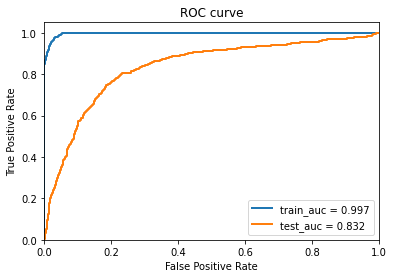

In [ ]:
svc_model = SVC(kernel = 'rbf', C = 4, gamma = 0.125)  #填入grid search的最佳C、gamma
svc_model.fit(X_train_Std, y_train)
plt.figure()
df_svc, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = model_evaluation_result(X_train_Std, y_train, X_test_Std, y_test, svc_model, 'train', 'test')
plt.show()

**Cross validation**
- indices

![img](https://i.imgur.com/eDcAW64.jpeg)

In [ ]:
#cv可設定要多少fold  #scoring可設定'f1_macro'、'recall_macro'、'precision_macro'、'accuracy'...
#scoring參數可參考:https://scikit-learn.org/stable/modules/model_evaluation.html
def confusion_matrix_scorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  return {'tn': cm[0, 0], 'fp': cm[0, 1],'fn': cm[1, 0], 'tp': cm[1, 1]}

cv_results = cross_validate(svc_model, X_train_Std, y_train, cv = 3, scoring = confusion_matrix_scorer)
tn = round(cv_results['test_tn'].mean())
fp = round(cv_results['test_fp'].mean())
fn = round(cv_results['test_fn'].mean())
tp = round(cv_results['test_tp'].mean())
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(cv_results['test_tn'], round(cv_results['test_tn'].mean()))
print(cv_results['test_fp'], round(cv_results['test_fp'].mean()))
print(cv_results['test_fn'], round(cv_results['test_fn'].mean()))
print(cv_results['test_tp'], round(cv_results['test_tp'].mean()))
print('accuracy:', accuracy)
print('precision:', precision)
print('sensitivity:', sensitivity)
print('specificity:', specificity)
print('MCC:', MCC)

[1084 1069 1073] 1075
[123 138 134] 132
[195 179 177] 184
[247 263 264] 258
accuracy: 0.8083687083080655
precision: 0.6615384615384615
sensitivity: 0.583710407239819
specificity: 0.8906379453189727
MCC: 0.494443870870684
